# Time Series Analysis

<img src="photo.jpg" style="width:100%;height:450px"/>

# Machine Learning, Deep Learning forecasting technique for machine operators.

Objective: Machinery world: Shops, Production, Machines, Operators. Machines vs Operators. Operators vs Managers. **How to answer the question when will  a machine will finish the order?** Machine operators use common sense calculating in mind  using experience as historical data to predict time when a machine is done. But how accurate are they? How to convince and verify their answer? Did they calculated accurately? They will  not even answer these type of questions for minutes. It will take all day. How will they calculate the process and future time in an hour, day, month scale? The Solution is Machine Learning, Deep Learning. There are algorithms that already can do this job for this problem:ARIMA, LSTM, even Facebook Prophet which Facebook developed for this purpose. I introduced techologies. Methodology is Time Series.Time Series forecasting  answer business questions like how much inventory to maintain, how much website traffic do you expect in your e-store to how many product will be sold in the next month.
This project is an attempt to simulate  a situation in a real world manufacturing company  with close to real data and to extract a conclusion from the experiment: what future size and what future time of a size as a computing a cutrate of a product size. 

The dataset is engineered for simplicity of the experiment as simple and meaningful as  possible to provide sufficiant  information for the algorithm to compute its forecast and ready to use without data wrangling.


# ARIMA Approach

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [5]:
# Import Train and Test Data 
from google.colab import drive
drive.mount("/content/gdrive/")
datafile = pd.read_csv('MLMachines.csv')
#datafile = pd.read_excel('MLMachinesShop.xlsx')
#columns = ['Basic_Size','Gr','Target_Pull_Size']
chart = pd.DataFrame(datafile)
chart

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,Basic_Size,Start_Size,size2,size3,size4,Time,Gr,Target_Pull_Size
0,3/16,0.00100,0.00090,0.00080,0.00070,2021-01-01,10,0.0001
1,5/32,0.00060,0.00085,0.00070,0.00030,2021-01-02,25,0.0000
2,5/16,0.00090,0.00080,0.00060,0.00030,2021-01-03,10,-0.0001
3,11/32,0.01200,0.00080,0.00060,0.00030,2021-01-04,25,0.0000
4,5/8,0.01195,0.00070,0.00050,0.00020,2021-01-05,24,0.0000
5,3/8,0.01528,0.00070,0.00046,0.00011,2021-01-06,10,0.0000
6,13/32,0.01861,0.00060,0.00042,0.00002,2021-01-07,25,0.0000
7,3/16,0.02194,0.00060,0.00038,-0.00007,2021-01-08,25,0.0005
8,5/32,0.02527,0.00050,0.00034,-0.00016,2021-01-09,25,-0.0005
9,5/16,0.02860,0.00050,0.00030,-0.00025,2021-01-10,25,0.0000


This dataset  is made of features  that are used  as regressors to find a taget feature future value. Basic size- size of an item in fractions. Start_size - size of an item at what it was before processing. Size_2,Size_3,Size_4  represent  machine number in which this item is processing. Time feature is day by day  representation.  Time and size features are correlated. Gr feature is a grade of an item by its quality. Target_Pull_Size is just a desired finish size for customer. It does not correlate to forcasting, it will compare only if an item is oversized or undersized at the moment of prediction

### Preparing the dataset for Time Series

In [6]:
from datetime import datetime
chart['Time']=pd.to_datetime(chart['Time'])

In [7]:
date_time = chart['Time']

### Time Series by Components

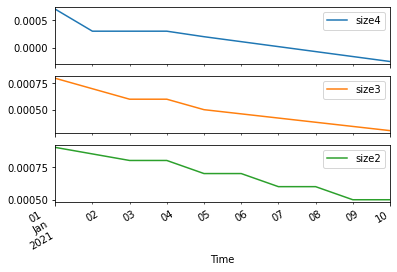

In [8]:
plot_cols = ['size4', 'size3','size2']
plot_features = chart[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [9]:
tb=chart.set_index(['Time'])
tb.head()

,Basic_Size,Start_Size,size2,size3,size4,Gr,Target_Pull_Size
Time,,,,,,,
2021-01-01,3/16,0.00100,0.00090,0.0008,0.0007,10,0.0001
2021-01-02,5/32,0.00060,0.00085,0.0007,0.0003,25,0.0000
2021-01-03,5/16,0.00090,0.00080,0.0006,0.0003,10,-0.0001
2021-01-04,11/32,0.01200,0.00080,0.0006,0.0003,25,0.0000
2021-01-05,5/8,0.01195,0.00070,0.0005,0.0002,24,0.0000


#### X  and Y regressors and predictors.

In [10]:
#x and y axes input data
y = tb['size4']
x =  tb.drop(['size4'], axis = 1)

Peeking at how  Y data  trend behaves

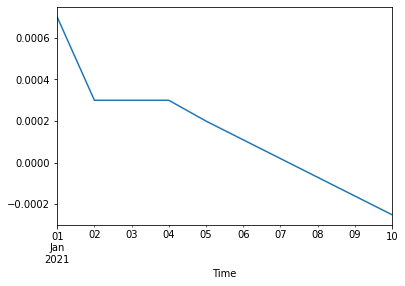

In [11]:
y.plot()

When doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary

In [12]:
from statsmodels.tsa.stattools import kpss
kpss(y, nlags='legacy')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TypeError: ignored

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [13]:
#preprocessing 
from sklearn.preprocessing import OneHotEncoder
traindfcat = x.select_dtypes(include ='object') 
enc = OneHotEncoder(sparse=False)
X_transfCat = enc.fit_transform(traindfcat)

### The ARIMA model

ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the sklearn and statsmodels libraries, and in particular mean_squared_error and ARIMA.

In [14]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

Make a function to find the MSE of a single ARIMA model¶

In [15]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

Make a function to evaluate the different ARIMA models with different p, d, and q values

In [16]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [17]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [18]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
Best ARIMA(0, 1, 1) MSE=0.000


In [19]:
p=0
d=1
q=1
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(48)

In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.size4   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  70.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sat, 27 Feb 2021   AIC                           -134.245
Time:                        22:29:58   BIC                           -133.654
Sample:                    01-02-2021   HQIC                          -135.522
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.387e-05   1.24e-05     -7.584      0.000      -0.000   -6.96e-05
ma.L1.D.size4    -0.4387        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            2.2797           +0.0000j            2.2797            0.0000
-----------------------------------------------------------------------------
"""

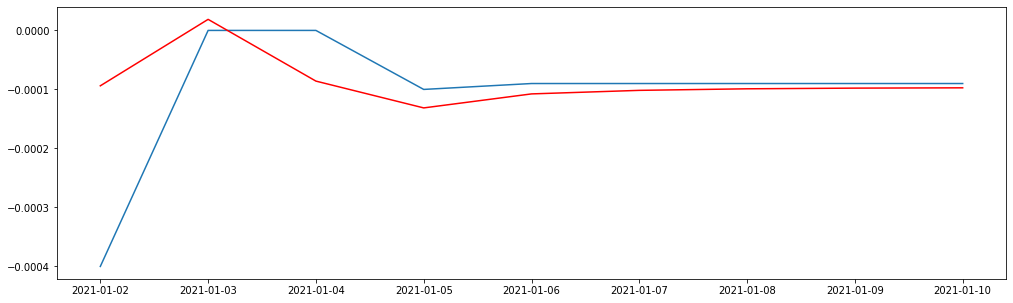

In [21]:
import matplotlib as plt

from matplotlib import *
import sys
import pylab as pl
pl.figure( figsize =(17,5) )
pl.plot(y.diff())
pl.plot(model_fit.predict(),color='red')

Model fits pretty closely to our actual data. 

#### Application: Forecasting

In [24]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 48
date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='8H').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions

future_months = pd.DataFrame(date_range, columns = ['Hour'])
future_months['Hour'] = pd.to_datetime(future_months['Hour'])
future_months.set_index('Hour', inplace = True)
future_months['Prediction'] = forecast[0]
yforecast = y.append(future_months['Prediction'])
yforecast
y_hats  = pd.DataFrame({'A' : yforecast})
y_hats 


,A
2021-01-01,0.000700
2021-01-02,0.000300
2021-01-03,0.000300
2021-01-04,0.000300
2021-01-05,0.000200
2021-01-06,0.000110
2021-01-07,0.000020
2021-01-08,-0.000070
2021-01-09,-0.000160
2021-01-10,-0.000250


In [22]:
y_hats.reset_index(inplace=True)


NameError: ignored

In [37]:
y_hats

,index,A
0,2021-01-01,0.000700
1,2021-01-02,0.000300
2,2021-01-03,0.000300
3,2021-01-04,0.000300
4,2021-01-05,0.000200
5,2021-01-06,0.000110
6,2021-01-07,0.000020
7,2021-01-08,-0.000070
8,2021-01-09,-0.000160
9,2021-01-10,-0.000250


In [38]:
y_hats.index[yforcast == -0.00394]

Int64Index([], dtype='int64')

In [39]:
y_hats.loc[y_hats['A'] == 0.000200, 'index']

4   2021-01-05
Name: index, dtype: datetime64[ns]

In [40]:
np.where(y_hats["A"]==-0.003867)

(array([], dtype=int64),)

In [41]:
search = '-0.004308' 
y_hats.loc[y_hats.isin([search]).any(axis=1)].index.tolist()

[]

In [42]:
yforcast[yforcast == -0.004308]

Series([], dtype: float64)

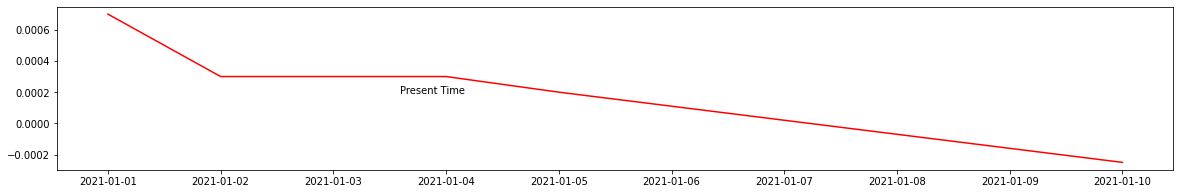

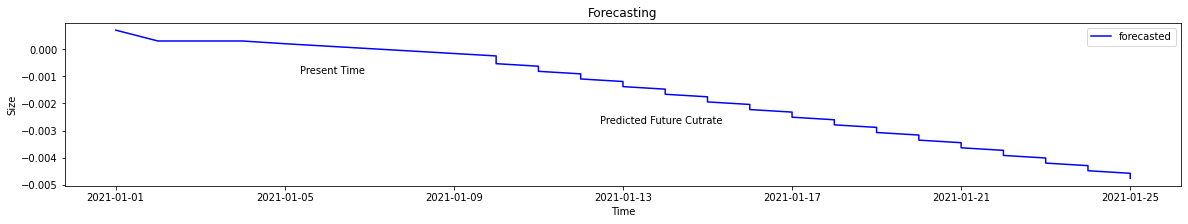

In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
fig1 = plt.figure()
fig2 = plt.figure()

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

ax1.plot(y, color = 'red', label = 'Present')

ax2.plot(yforecast, color = 'blue', label = 'forecasted')
ax1.annotate('Present Time',
            xy=(400, 100), xycoords='figure pixels')
ax2.annotate('Present Time',
            xy=(300, 150), xycoords='figure pixels')
ax2.annotate('Predicted Future Cutrate',
            xy=(600, 100), xycoords='figure pixels')
pl.title('Forecasting')
pl.xlabel('Time')
pl.ylabel('Size')
pl.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# calculate out of sample error
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    rmse = sqrt(error)
    return rmse


In [44]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s MSE=%.3f' % (order,rmse))
                except:
                    continue
    return print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [45]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
Best ARIMA(0, 1, 1) RMSE=0.000


# Facebook Prophet Approach

In the model training part and should not split the same into train and test.

In [46]:
# Import Train and Test Data 
from google.colab import drive
drive.mount("/content/gdrive/")
import pandas as pd
datafile = pd.read_excel('FBdataset.xlsx')

data = pd.DataFrame(datafile)
data.head()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,y,ds
0,0.0007,2021-01-01
1,0.0003,2021-01-02
2,0.0003,2021-01-03
3,0.0003,2021-01-04
4,0.0002,2021-01-05


In [47]:
datarev = data[data.columns[::-1]]


Changing the data type of the date column to Date time:

In [48]:
datarev.columns = ['ds','y']
#convert column "date" into datetime format
datarev['ds'] = pd.to_datetime(datarev.ds)

In [49]:
datarev.head()

,ds,y
0,2021-01-01,0.0007
1,2021-01-02,0.0003
2,2021-01-03,0.0003
3,2021-01-04,0.0003
4,2021-01-05,0.0002


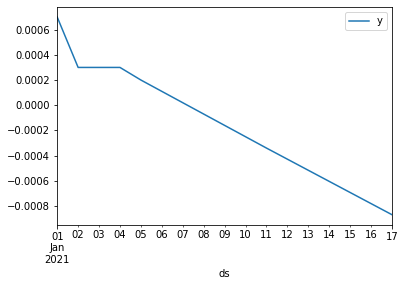

In [50]:
datarev.plot(x='ds')

In [51]:

from fbprophet import Prophet

model=Prophet()




In [52]:
model.fit(datarev)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


Creating the future dataset with the help of the Prophet so that we make predictions on unseen data:

In [53]:
future = model.make_future_dataframe(periods = 365)


In [54]:
datarev.tail()

,ds,y
12,2021-01-13,-0.000516
13,2021-01-14,-0.000605
14,2021-01-15,-0.000693
15,2021-01-16,-0.000781
16,2021-01-17,-0.000869


In [55]:
future.tail()

,ds
377,2022-01-13
378,2022-01-14
379,2022-01-15
380,2022-01-16
381,2022-01-17


Making predictions:

In [56]:
pred = model.predict(future)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,0.000538,0.000533,0.000651,0.000538,0.000538,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.0,0.0,0.0,0.000592
1,2021-01-02,0.000450,0.000340,0.000459,0.000450,0.000450,-0.000051,-0.000051,-0.000051,-0.000051,-0.000051,-0.000051,0.0,0.0,0.0,0.000399
2,2021-01-03,0.000363,0.000282,0.000396,0.000363,0.000363,-0.000023,-0.000023,-0.000023,-0.000023,-0.000023,-0.000023,0.0,0.0,0.0,0.000339
3,2021-01-04,0.000275,0.000228,0.000349,0.000275,0.000275,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.0,0.0,0.0,0.000286
4,2021-01-05,0.000188,0.000137,0.000252,0.000188,0.000188,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.0,0.0,0.0,0.000192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2022-01-13,-0.032460,-0.032520,-0.032403,-0.032460,-0.032460,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.0,0.0,0.0,-0.032458
378,2022-01-14,-0.032547,-0.032552,-0.032434,-0.032547,-0.032547,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.0,0.0,0.0,-0.032493
379,2022-01-15,-0.032635,-0.032744,-0.032625,-0.032635,-0.032635,-0.000051,-0.000051,-0.000051,-0.000051,-0.000051,-0.000051,0.0,0.0,0.0,-0.032686
380,2022-01-16,-0.032722,-0.032803,-0.032687,-0.032722,-0.032722,-0.000023,-0.000023,-0.000023,-0.000023,-0.000023,-0.000023,0.0,0.0,0.0,-0.032746


yhat means the predicted output based on the input fed to the model, yhat_lower, and upper means the upper and lower value that can go based on the predicted output that is, the fluctuations that can happen.

Getting the desired columns:

In [57]:
pred[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,0.000592,0.000533,0.000651
1,2021-01-02,0.000399,0.000340,0.000459
2,2021-01-03,0.000339,0.000282,0.000396
3,2021-01-04,0.000286,0.000228,0.000349
4,2021-01-05,0.000192,0.000137,0.000252


Plotting the output:

Hereunder the plot we can see the predictions made by the Prophet library. The dotted lines represent the actual data points that we specified in the training part. The lines represent the predictions made. Also, we can see the predictions made on the unseen data that we created with only lines at the extreme right-hand side. For verification purposes, you can match the data frame timestamps with the graph.

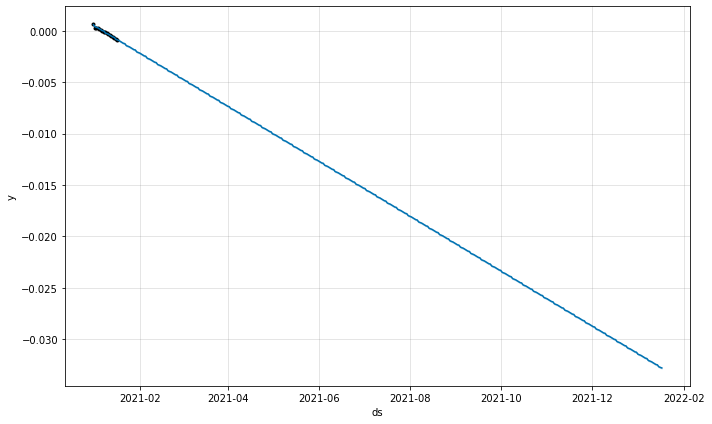

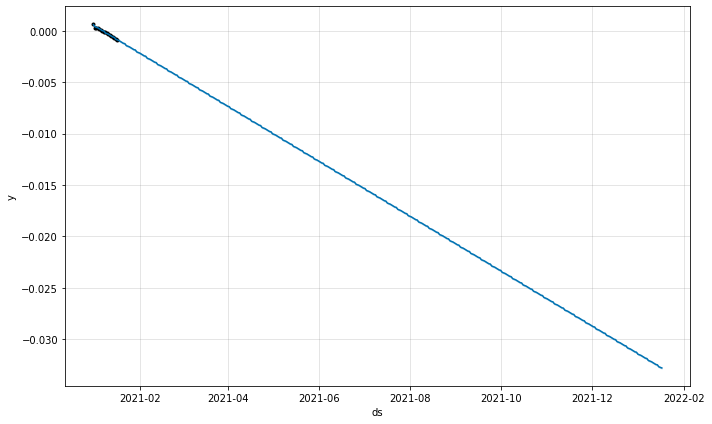

In [58]:
model.plot(pred)

Checking the trends in the data: 

Below we can see the trends with respect to year and months in the year.The first graph represents a decreasing trend as we progress in the years.

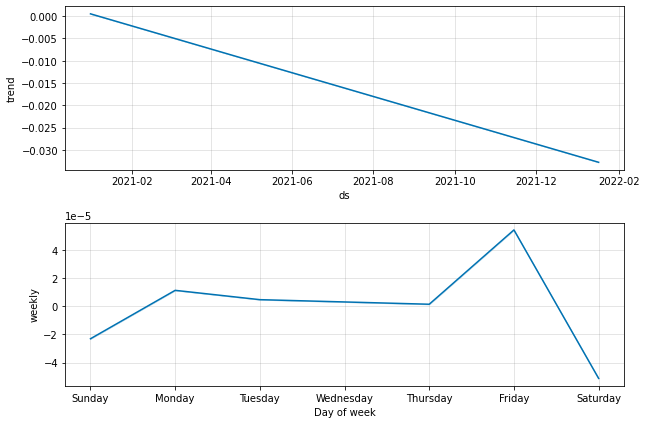

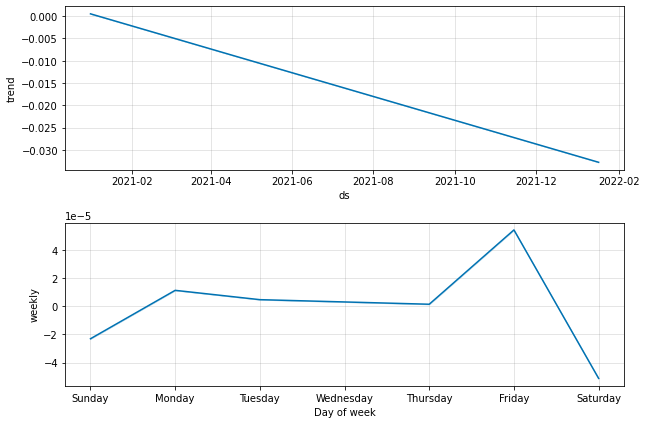

In [59]:
model.plot_components(pred)

# LSTM Model Approach

I needed to reshape input data to transform it into Neural networks compatible

In [10]:
#x and y axes input data


y = tb['size4']
#x =  tb.drop(['size4'], axis = 1)
#x =  tb.drop(['size4','Basic_Size', 'Gr','Start_Size','Target_Pull_Size'], axis = 1)
#x.transpose()

In [11]:
X = tb.loc[:,tb.columns!='size4']
from sklearn.preprocessing import OneHotEncoder
traindfcat = X.select_dtypes(include ='object') 
enc = OneHotEncoder(sparse=False)
X_transfCat = enc.fit_transform(traindfcat)

In [12]:
Xx = np.array(X_transfCat)
Yy = np.array(y)

Here is the model itself

In [17]:

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense 
from keras.callbacks import EarlyStopping

x_train = np.expand_dims(Xx, 1)
# define model
model = Sequential()
model.add(LSTM(1, input_shape=(1,7), activation='relu', return_sequences=True))
model.add(LSTM(1,input_shape=(1,7)))
model.compile(optimizer='adam', loss='mse')

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 1)              36        
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 12        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#fitting the model
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(x_train, y , batch_size = 10240, epochs = 100, verbose = False,validation_split=0.3,callbacks=[early_stopping_monitor])


In [20]:
#output the forecasted data
yhat = model.predict(x_train, verbose=0)
print(yhat)

[[-0.00600726]
 [-0.00544093]
 [ 0.0091289 ]
 [ 0.0091289 ]
 [-0.00935604]
 [-0.00190141]
 [ 0.0091289 ]
 [-0.00600726]
 [-0.00544093]
 [ 0.0091289 ]]


In [21]:
preds = pd.DataFrame(yhat)
preds

,0
0,-0.006007
1,-0.005441
2,0.009129
3,0.009129
4,-0.009356
5,-0.001901
6,0.009129
7,-0.006007
8,-0.005441
9,0.009129


In [ ]:
yforcast = y.append(future_months['Prediction'])

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(y, yhat)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.007505


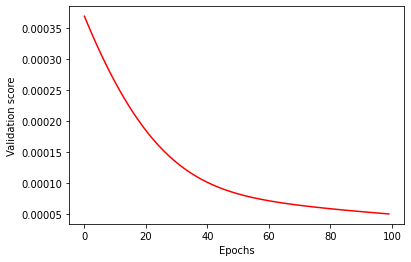

In [24]:
#visualise how the model trains itself
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Create the plot
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

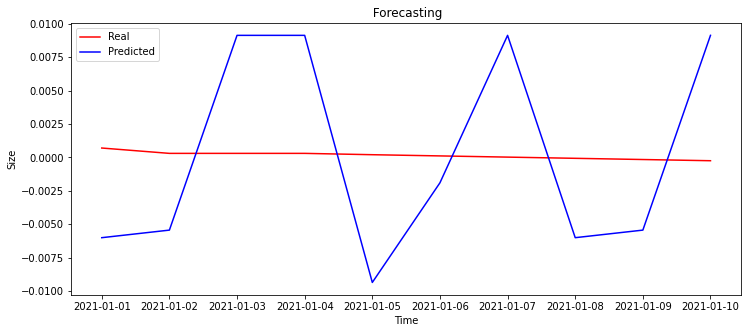

In [25]:
# Visualising the results
import matplotlib as plt

from matplotlib import *
import sys
import pylab as pl
pl.figure( figsize =(12,5) )
pl.plot(y, color = 'red', label = 'Real')
pl.plot(x.index, yhat, color = 'blue', label = 'Predicted')
pl.title(' Forecasting')
pl.xlabel('Time')
pl.ylabel('Size')
pl.legend()
pl.show()

### Evaluating and Concluding

This was a valuable experience. I found out that Facebook Prophet has a contraint to input data: two variables only. I Learned details about building ARIMA and LSTM . I did not like Facebook Prophet as it can take only two column features to compute forcasting. It also  is not compatable to my computer as it is a new developing  technology. In m case I would say the winner is ARIMA. Because it really forecasted future in a more readable format and takes as many features as I want. LSTM here only tells the difference between predicted and actual data wich was computed by neural network.  I will continue to research features, advantages, and disadvantages.